## Background

Analysis ready data (ARD) is data that has been processed to improve ease-of-use for an end user. This includes the process of applying corrections, for example, removing the atmospheric effects that appear in imagery. In this notebook, we work with Landsat data and will comparing unprocessed (Level-1) data with processed (Level-2, or analysis ready) data. 

When working with optical data, a common analysis method is to calculate various band indices. These are typically constructed as the ratio between the sum of two bands and their difference:
$$\text{Index} = \frac{\text{Band 1} - \text{Band 2}}{\text{Band 1} + \text{Band 2}}.$$
In particular, band indices are commonly used to extract information on vegetation coverage or classify water pixels. 

Given the level of processing required, it's worth understanding whether band-index analyses can be carried out with Level-1 data as opposed to Level-2 data. In this notebook, we calculate key band indicies for Landsat Level-1 and Level-2 products and compare them.

## Import packages

In [1]:
%matplotlib inline
import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../Scripts')
from utils import lat_lon_to_epsg, three_band_image
from dc_display_map import display_map

from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

## Available Landsat products
The `list_products` method in the Datacube class displays the names and details of all available products. In the below cell we will query what Landsat 8 Products are currently indexed in our instance.

In [28]:
# Connect to a datacube
dc = datacube.Datacube(app='Level 1 and Level 2 Comparison')

# List metadata for all Landsat NBAR and NBART products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type']
dc_products[dc_products['name'].str.contains("ls8|ls8")][display_columns].set_index('name')

,description,product_type
name,,
ga_ls8c_gm_2_annual,"Annual Geometric Median, Landsat 8",NaN
ga_ls8c_wofs_2,Historic Flood Mapping Water Observations from...,NaN
ga_ls8c_wofs_2_annual_summary,Water Observations from Space Annual Statistics,NaN
ga_ls8c_wofs_2_summary,Water Observations from Space Full History Sta...,NaN
ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Higher Level SR sc...,LEVEL2_USGS


Level-1 data has product name `ls8_level1_usgs`. Level-2 data has product name `ls8_usgs_sr_scene`.

## Visualise and load data

In [23]:
# The coordinates below correspond to an area containing Lake Rweru,
# which is on the boarder of Rwanda and Burundi
latitude = (-2.2, -2.45)
longitude  = (30.1, 30.35)

# Date range to load over
date_range = ("2018-01-01", "2018-02-01")

# Display the map before loading the data
display_map(latitude, longitude)

In [24]:
# Get the EPSG of a WGS UTM coordinate reference system that is appropriate for our data
EPSG = lat_lon_to_epsg(latitude[1], longitude[1])

# Load the Level-1 data
# data_cube_level1 = dc.load(
#     product='ls8_level1_usgs',
#     x=longitude,
#     y=latitude, 
#     output_crs='epsg:' + EPSG,
#     resolution=(-30, 30),
#     time = date_range,
#     measurements = ['nir', 'red', 'swir1', 'green', 'blue']
# )
# print(data_cube_level1)

# Load the Level-2 data
data_cube_level2 = dc.load(
    product='ls8_usgs_sr_scene',
    x=longitude,
    y=latitude, 
    output_crs='epsg:' + EPSG,
    resolution=(-30, 30),
    time = date_range,
    measurements = ['nir', 'red', 'swir1', 'green', 'blue']
)
print(data_cube_level2)

<xarray.Dataset>
Dimensions:      (time: 7, x: 930, y: 925)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-09T08:08:00.296950 ... 2018-02-01T08:14:21.761724
  * y            (y) float64 9.757e+06 9.757e+06 ... 9.729e+06 9.729e+06
  * x            (x) float64 1.774e+05 1.774e+05 ... 2.052e+05 2.053e+05
    spatial_ref  int32 32736
Data variables:
    nir          (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    red          (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    green        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    blue         (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:           epsg:32736
    grid_mapping:  spatial_ref


## Calculate various band indices

For the demonstrative purpose of this notebook, we calculate three indices:

### NDVI
The normalised difference vegetation index (NDVI) indicates the presence of green vegetation. It is calculated as
$$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}$$
High values indicate dense vegetation.

### NDWI
The normalised difference water index (NDWI) indicates the presence of water. It is calculated as
$$\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}$$
High values indicate water.

### MNDWI
The modified normalised difference water index (MNDWI) indicates the presence of water. It is calculated as
$$\text{MNDWI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}$$
High values indicate water. This index provides enhanced water classification relative to the NDWI.

In the following cell, we define a function to calculate and add each index to a given data cube object. The band indices are stored as individual data varaiables.

In [25]:
def calculate_band_indices(dc):
    dc['ndvi'] = (dc.nir - dc.red)/(dc.nir + dc.red)
    dc['ndwi'] = (dc.green - dc.nir)/(dc.green + dc.nir)
    dc['mndwi'] = (dc.green - dc.swir1)/(dc.nir + dc.swir1)
    return(dc)

In [26]:
#dc_level1 = calculate_band_indices(data_cube_level1)
dc_level2 = calculate_band_indices(data_cube_level2)

## Plot indices for same time stamp

We now show the index values for the same time step. Band indices are designed to occur on a scale of -1 to 1, so we keep these as the bounds for the colour maps in both images. Consequently, the intensity of the colour can be directly compared.

Run the following commands to see the available time-steps for the Level-1 and Level-2 data cube objects:

In [27]:
#print(dc_level1.time)
print(dc_level2.time)

<xarray.DataArray 'time' (time: 7)>
array(['2018-01-09T08:08:00.296950000', '2018-01-09T08:08:24.217641000',
       '2018-01-16T08:14:07.739591000', '2018-01-25T08:07:51.698941000',
       '2018-01-25T08:08:15.619630000', '2018-02-01T08:13:57.841033000',
       '2018-02-01T08:14:21.761724000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2018-01-09T08:08:00.296950 ... 2018-02-01T08:14:21.761724
    spatial_ref  int32 32736
Attributes:
    units:    seconds since 1970-01-01 00:00:00


We start by stating which time steps to use for plotting. Choose index values that give the same times, noting that the times may not perfectly match between the Level-1 and Level-2 data cubes.

The choices below correspond to the same time-stamp in the Level-1 and Level-2 data sets, which is an image with minimal cloud coverage.

In [16]:
#dc_level1_plotindex = 4
dc_level2_plotindex = 3

### NDVI

NameError: name 'dc_level1' is not defined

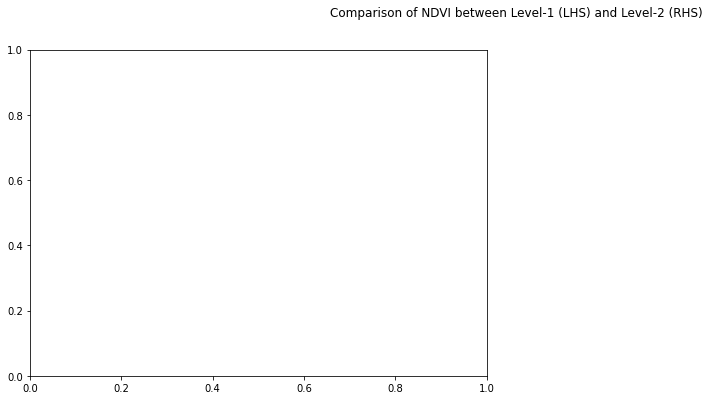

In [17]:
fig = plt.figure(figsize=(18,6))
fig.suptitle("Comparison of NDVI between Level-1 (LHS) and Level-2 (RHS)")

plt.subplot(121)
dc_level1.ndvi.isel(time=dc_level1_plotindex).plot(cmap='RdYlGn', vmin=-1, vmax=1)

plt.subplot(122)
dc_level2.ndvi.isel(time=dc_level2_plotindex).plot(cmap='RdYlGn', vmin=-1, vmax=1)

plt.show()

### NDWI

In [ ]:
fig2 = plt.figure(figsize=(18,6))
fig2.suptitle("Comparison of NDWI between Level-1 (LHS) and Level-2 (RHS)")

plt.subplot(121)
dc_level1.ndwi.isel(time=dc_level1_plotindex).plot(cmap='GnBu', vmin=-1, vmax=1)

plt.subplot(122)
dc_level2.ndwi.isel(time=dc_level2_plotindex).plot(cmap='GnBu', vmin=-1, vmax=1)

plt.show()

### MNDWI

In [ ]:
fig3 = plt.figure(figsize=(18,6))
fig3.suptitle("Comparison of MNDWI between Level-1 (LHS) and Level-2 (RHS)")

plt.subplot(121)
dc_level1.mndwi.isel(time=dc_level1_plotindex).plot(cmap='RdBu', vmin=-1, vmax=1)

plt.subplot(122)
dc_level2.mndwi.isel(time=dc_level2_plotindex).plot(cmap='RdBu', vmin=-1, vmax=1)

plt.show()

## Plot histograms of difference in index values between Level-1 and Level-2

We can assess the distribution of the difference in the index values by taking a histogram of the difference in the index values. A value of 0 difference would indicate that the value of the index is the same in the Level 1 and Level 2 data.

### NDVI

In [ ]:
ndvi_diff = dc_level2.ndvi.isel(time=dc_level2_plotindex) - dc_level1.ndvi.isel(time=dc_level1_plotindex)

fig4 = plt.figure(figsize=(6,6))
ndvi_diff.plot.hist(bins=100)
plt.title('Histogram of difference in NDVI (Level-2 - Level-1)')
plt.show()

### NDWI

In [ ]:
ndwi_diff = dc_level2.ndwi.isel(time=dc_level2_plotindex) - dc_level1.ndwi.isel(time=dc_level1_plotindex)

fig5 = plt.figure(figsize=(6,6))
ndwi_diff.plot.hist(bins=100)
plt.title('Histogram of difference in NDWI (Level-2 - Level-1)')
plt.show()

### MNDWI

We note that there are some extreme values in the Level 1 data due to the presence of clouds, so we don't plot the difference values that are smaller than -2.

In [ ]:
mndwi_diff = dc_level2.mndwi.isel(time=dc_level2_plotindex) - dc_level1.mndwi.isel(time=dc_level1_plotindex)
filtered_mndwi_diff = mndwi_diff.where(mndwi_diff > -2)

fig6 = plt.figure(figsize=(6,6))
filtered_mndwi_diff.plot.hist(bins=100)
plt.title('Histogram of difference in MNDWI (Level-2 - Level-1)')
plt.show()

## Conclusion

The visual inspection and histograms reveal that the band indices calculated for Level-1 and Level-2 data differ for the vast majority of pixels. Clouds also have spurious index values in the Level-1 data, which might also affect analyses. We conclude that you could not necessarily use the index values from Level-1 in place of those from Level-2.